# Building a value-weighted index

In this notebook you create a **value-weighted index**. This index uses market-cap data contained in the stock exchange listings to calculate weights and 2016 stock price information. Index performance is then compared against benchmarks to evaluate the performance of the index you created.

## Table of Contents

- [Select index components & import data](#intro)
- [Build a market-cap weighted index](#build)
- [Evaluate index performance](#eval)
- [Index correlation & exporting to excel](#corr)

In [76]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

path = "data/dc27/"

---
<a id='intro'></a>

## Select index components & import data

## Explore and clean company listing information

To get started with the construction of a **market-value based index**, you'll work with the combined listing info for the three largest US stock exchanges, the NYSE, the NASDAQ and the AMEX.

In this and the next exercise, you will calculate **market-cap weights** for these stocks.

We have already imported pandas as pd, and loaded the `listings` data set with listings information from the NYSE, NASDAQ, and AMEX. The column 'Market Capitalization' is already measured in USD mn.

In [5]:
listings = pd.read_csv(path+'listings.csv', index_col=0)
listings.head()

,Exchange,Stock Symbol,Company Name,Last Sale,Market Capitalization,IPO Year,Sector,Industry
0,amex,XXII,"22nd Century Group, Inc",1.3300,120.628490,NaN,Consumer Non-Durables,Farming/Seeds/Milling
1,amex,FAX,Aberdeen Asia-Pacific Income Fund Inc,5.0000,1266.332595,1986.0,NaN,NaN
2,amex,IAF,Aberdeen Australia Equity Fund Inc,6.1500,139.865305,NaN,NaN,NaN
3,amex,CH,"Aberdeen Chile Fund, Inc.",7.2201,67.563458,NaN,NaN,NaN
4,amex,ABE,Aberdeen Emerging Markets Smaller Company Oppo...,13.3600,128.842972,NaN,NaN,NaN


In [6]:
# Inspect listings
print(listings.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6674 entries, 0 to 6673
Data columns (total 8 columns):
Exchange                 6674 non-null object
Stock Symbol             6674 non-null object
Company Name             6674 non-null object
Last Sale                6590 non-null float64
Market Capitalization    6674 non-null float64
IPO Year                 2852 non-null float64
Sector                   5182 non-null object
Industry                 5182 non-null object
dtypes: float64(3), object(5)
memory usage: 469.3+ KB
None


In [7]:
# Move 'stock symbol' into the index
listings.set_index('Stock Symbol', inplace=True)
listings.head()

,Exchange,Company Name,Last Sale,Market Capitalization,IPO Year,Sector,Industry
Stock Symbol,,,,,,,
XXII,amex,"22nd Century Group, Inc",1.3300,120.628490,NaN,Consumer Non-Durables,Farming/Seeds/Milling
FAX,amex,Aberdeen Asia-Pacific Income Fund Inc,5.0000,1266.332595,1986.0,NaN,NaN
IAF,amex,Aberdeen Australia Equity Fund Inc,6.1500,139.865305,NaN,NaN,NaN
CH,amex,"Aberdeen Chile Fund, Inc.",7.2201,67.563458,NaN,NaN,NaN
ABE,amex,Aberdeen Emerging Markets Smaller Company Oppo...,13.3600,128.842972,NaN,NaN,NaN


In [8]:
# Drop rows with missing 'sector' data
listings.dropna(subset=['Sector'], inplace=True)
listings.head()

,Exchange,Company Name,Last Sale,Market Capitalization,IPO Year,Sector,Industry
Stock Symbol,,,,,,,
XXII,amex,"22nd Century Group, Inc",1.33,120.628490,NaN,Consumer Non-Durables,Farming/Seeds/Milling
ACU,amex,Acme United Corporation.,27.39,91.138992,1988.0,Capital Goods,Industrial Machinery/Components
AIII,amex,"ACRE Realty Investors, Inc.",1.16,23.768939,NaN,Consumer Services,Real Estate Investment Trusts
ATNM,amex,"Actinium Pharmaceuticals, Inc.",1.47,82.037381,NaN,Health Care,Major Pharmaceuticals
AE,amex,"Adams Resources & Energy, Inc.",37.80,159.425129,NaN,Energy,Oil Refining/Marketing


In [9]:
# Select companies with IPO Year before 2019
listings = listings.loc[listings['IPO Year'] < 2019]
listings.head()

,Exchange,Company Name,Last Sale,Market Capitalization,IPO Year,Sector,Industry
Stock Symbol,,,,,,,
ACU,amex,Acme United Corporation.,27.3900,91.138992,1988.0,Capital Goods,Industrial Machinery/Components
AAU,amex,"Almaden Minerals, Ltd.",1.7200,154.891745,2015.0,Basic Industries,Precious Metals
USAS,amex,Americas Silver Corporation,3.0500,120.694838,2017.0,Basic Industries,Precious Metals
AINC,amex,Ashford Inc.,57.3373,115.550771,2014.0,Consumer Services,Professional Services
AUXO,amex,"Auxilio, Inc.",6.3043,59.131037,2017.0,Miscellaneous,Business Services


In [10]:
# Inspect the new listings data
print(listings.info())

<class 'pandas.core.frame.DataFrame'>
Index: 2349 entries, ACU to ZTO
Data columns (total 7 columns):
Exchange                 2349 non-null object
Company Name             2349 non-null object
Last Sale                2349 non-null float64
Market Capitalization    2349 non-null float64
IPO Year                 2349 non-null float64
Sector                   2349 non-null object
Industry                 2349 non-null object
dtypes: float64(3), object(4)
memory usage: 146.8+ KB
None


In [11]:
# Show the number of companies per sector
print(listings.groupby('Sector').size().sort_values(ascending=False))

Sector
Health Care              445
Consumer Services        402
Technology               386
Finance                  351
Energy                   144
Capital Goods            143
Public Utilities         104
Basic Industries         104
Consumer Non-Durables     89
Miscellaneous             68
Transportation            58
Consumer Durables         55
dtype: int64


## Select and inspect index components

Now that you have imported and cleaned the `listings` data, you can proceed to select the index components as the largest company for each sector by market capitalization.

You'll also have the opportunity to take a closer look at the components, their last market value, and last price.

In [17]:
# Select largest company for each sector
components = listings.groupby('Sector')['Market Capitalization'].nlargest(1)

In [16]:
# Print components, sorted by market cap
print(components.sort_values(ascending=False))

Sector                 Stock Symbol
Technology             AAPL            740024.467000
Consumer Services      AMZN            422138.530626
Miscellaneous          BABA            275525.000000
Health Care            AMGN            118927.210535
Transportation         UPS              90180.886756
Finance                GS               88840.590477
Consumer Non-Durables  ABEV             88240.198455
Basic Industries       RIO              70431.476895
Public Utilities       TEF              54609.806092
Capital Goods          GM               50086.335099
Energy                 PAA              22223.001416
Consumer Durables      CPRT             13620.922869
Name: Market Capitalization, dtype: float64


In [18]:
# Select stock symbols and print the result
tickers = components.index.get_level_values('Stock Symbol')
print(tickers)

Index(['RIO', 'GM', 'CPRT', 'ABEV', 'AMZN', 'PAA', 'GS', 'AMGN', 'BABA', 'TEF',
       'AAPL', 'UPS'],
      dtype='object', name='Stock Symbol')


In [20]:
# Print company name, market cap, and last price for each component
info_cols = ['Company Name', 'Market Capitalization', 'Last Sale']
info_cols = listings.loc[tickers, info_cols].sort_values('Market Capitalization', ascending=False)
info_cols

,Company Name,Market Capitalization,Last Sale
Stock Symbol,,,
AAPL,Apple Inc.,740024.467000,141.05
AMZN,"Amazon.com, Inc.",422138.530626,884.67
BABA,Alibaba Group Holding Limited,275525.000000,110.21
AMGN,Amgen Inc.,118927.210535,161.61
UPS,"United Parcel Service, Inc.",90180.886756,103.74
GS,"Goldman Sachs Group, Inc. (The)",88840.590477,223.32
ABEV,Ambev S.A.,88240.198455,5.62
RIO,Rio Tinto Plc,70431.476895,38.94
TEF,Telefonica SA,54609.806092,10.84


## Import index component price information

Now you'll use the stock symbols for the companies you selected in the last exercise to calculate returns for each company.

In [21]:
# Print tickers
print(tickers)

Index(['RIO', 'GM', 'CPRT', 'ABEV', 'AMZN', 'PAA', 'GS', 'AMGN', 'BABA', 'TEF',
       'AAPL', 'UPS'],
      dtype='object', name='Stock Symbol')


In [22]:
# Import prices and inspect result
stock_prices = pd.read_csv(path+'stock_data.csv', parse_dates=['Date'], index_col='Date')
print(stock_prices.info())
stock_prices.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1762 entries, 2010-01-04 to 2016-12-30
Data columns (total 12 columns):
AAPL    1761 non-null float64
AMGN    1761 non-null float64
AMZN    1761 non-null float64
CPRT    1761 non-null float64
EL      1762 non-null float64
GS      1762 non-null float64
ILMN    1761 non-null float64
MA      1762 non-null float64
PAA     1762 non-null float64
RIO     1762 non-null float64
TEF     1762 non-null float64
UPS     1762 non-null float64
dtypes: float64(12)
memory usage: 179.0 KB
None


,AAPL,AMGN,AMZN,CPRT,EL,GS,ILMN,MA,PAA,RIO,TEF,UPS
Date,,,,,,,,,,,,
2010-01-04,30.57,57.72,133.90,4.55,24.27,173.08,30.55,25.68,27.00,56.03,28.55,58.18
2010-01-05,30.63,57.22,134.69,4.55,24.18,176.14,30.35,25.61,27.30,56.90,28.53,58.28
2010-01-06,30.14,56.79,132.25,4.53,24.25,174.26,32.22,25.56,27.29,58.64,28.23,57.85
2010-01-07,30.08,56.27,130.00,4.50,24.56,177.67,32.77,25.39,26.96,58.65,27.75,57.41
2010-01-08,30.28,56.77,133.52,4.52,24.66,174.31,33.15,25.40,27.05,59.30,27.57,60.17


In [23]:
# Calculate the returns  
price_return = stock_prices.iloc[-1].div(stock_prices.iloc[0]).sub(1).mul(100)

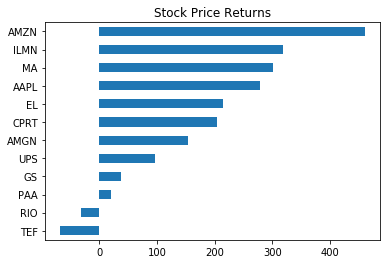

In [24]:
# Plot horizontal bar chart of sorted price_return   
price_return.sort_values().plot(kind='barh', title='Stock Price Returns')
plt.show();

---
<a id='build'></a>

## Build a market-cap weighted index

## Calculate number of shares outstanding

The next step towards building a **value-weighted index** is to calculate the number of shares for each index component.

The number of shares will allow you to calculate the total market capitalization for each component given the historical price series in the next exercise.

In [25]:
# Inspect listings and print tickers
print(listings.info())

<class 'pandas.core.frame.DataFrame'>
Index: 2349 entries, ACU to ZTO
Data columns (total 7 columns):
Exchange                 2349 non-null object
Company Name             2349 non-null object
Last Sale                2349 non-null float64
Market Capitalization    2349 non-null float64
IPO Year                 2349 non-null float64
Sector                   2349 non-null object
Industry                 2349 non-null object
dtypes: float64(3), object(4)
memory usage: 226.8+ KB
None


In [26]:
print(tickers)

Index(['RIO', 'GM', 'CPRT', 'ABEV', 'AMZN', 'PAA', 'GS', 'AMGN', 'BABA', 'TEF',
       'AAPL', 'UPS'],
      dtype='object', name='Stock Symbol')


In [40]:
# Select components and relevant columns from listings
components = listings.loc[tickers, ['Market Capitalization', 'Last Sale']]

In [41]:
# Print the first rows of components
print(components.head())

              Market Capitalization  Last Sale
Stock Symbol                                  
RIO                    70431.476895      38.94
GM                     50086.335099      33.39
CPRT                   13620.922869      29.65
ABEV                   88240.198455       5.62
AMZN                  422138.530626     884.67


In [42]:
# Calculate the number of shares here
no_shares = components['Market Capitalization'].div(components['Last Sale'])
type(no_shares)

pandas.core.series.Series

In [43]:
# Print the sorted no_shares -> companies with most shares
print(no_shares.sort_values(ascending=False))

Stock Symbol
ABEV    15701.102928
AAPL     5246.540000
TEF      5037.804990
BABA     2500.000000
RIO      1808.717948
GM       1500.039985
UPS       869.297154
AMGN      735.890171
PAA       723.404994
AMZN      477.170618
CPRT      459.390316
GS        397.817439
dtype: float64


## Create time series of market value

You can now use the number of shares to calculate the total market capitalization for each component and trading date from the historical price series.

The result will be the key input to construct the value-weighted stock index, which you will complete in the next exercise.

In [44]:
components = pd.concat([components, no_shares], axis=1)
cols = list(components.columns)
cols[2] = 'Number of Shares'
components.columns = cols
components

,Market Capitalization,Last Sale,Number of Shares
Stock Symbol,,,
RIO,70431.476895,38.94,1808.717948
GM,50086.335099,33.39,1500.039985
CPRT,13620.922869,29.65,459.390316
ABEV,88240.198455,5.62,15701.102928
AMZN,422138.530626,884.67,477.170618
PAA,22223.001416,30.72,723.404994
GS,88840.590477,223.32,397.817439
AMGN,118927.210535,161.61,735.890171
BABA,275525.000000,110.21,2500.000000


In [45]:
# Select the number of shares
no_shares = components['Number of Shares']
print(no_shares.sort_values())

Stock Symbol
GS        397.817439
CPRT      459.390316
AMZN      477.170618
PAA       723.404994
AMGN      735.890171
UPS       869.297154
GM       1500.039985
RIO      1808.717948
BABA     2500.000000
TEF      5037.804990
AAPL     5246.540000
ABEV    15701.102928
Name: Number of Shares, dtype: float64


In [46]:
# Create the series of market cap per ticker
market_cap = stock_prices.mul(no_shares)

In [47]:
# Select first and last market cap here
first_value = market_cap.iloc[0]
last_value = market_cap.iloc[-1]

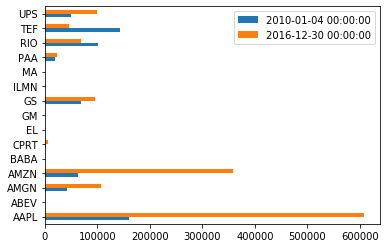

In [48]:
# Concatenate and plot first and last market cap here
pd.concat([first_value, last_value], axis=1).plot(kind='barh')
plt.show();

## Calculate & plot the composite index

By now you have all ingredients that you need to calculate the aggregate stock performance for your group of companies.

Use the time series of market capitalization that you created in the last exercise to aggregate the market value for each period, and then normalize this series to convert it to an index.

In [50]:
# Aggregate and print the market cap per trading day
raw_index = market_cap.sum(axis=1)
print(raw_index)

Date
2010-01-04    6.529794e+05
2010-01-05    6.562973e+05
2010-01-06    6.527435e+05
2010-01-07    6.492939e+05
2010-01-08    6.537965e+05
                  ...     
2016-12-23    1.425208e+06
2016-12-27    1.435541e+06
2016-12-28    1.431656e+06
2016-12-29    1.427209e+06
2016-12-30    1.413611e+06
Length: 1762, dtype: float64


In [51]:
# Normalize the aggregate market cap here 
index = raw_index.div(raw_index.iloc[0]).mul(100)
print(index)

Date
2010-01-04    100.000000
2010-01-05    100.508119
2010-01-06     99.963872
2010-01-07     99.435588
2010-01-08    100.125141
                 ...    
2016-12-23    218.262332
2016-12-27    219.844835
2016-12-28    219.249834
2016-12-29    218.568789
2016-12-30    216.486276
Length: 1762, dtype: float64


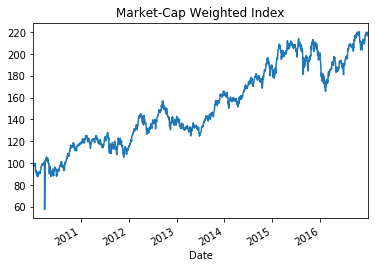

In [52]:
# Plot the index here
index.plot(title='Market-Cap Weighted Index')
plt.show();

---
<a id='eval'></a>

## Evaluate index performance

## Calculate the contribution of each stock to the index

You have successfully built the **value-weighted index**. Let's now explore how it performed over the 2010-2016 period. Let's also determine how much each stock has contributed to the index return.

In [53]:
# Calculate and print the index return here
index_return = (index[-1] / index[0] - 1) * 100
print(index_return)

116.48627582170694


In [54]:
# Select the market capitalization
market_cap = components['Market Capitalization']

In [55]:
# Calculate the total market cap
total_market_cap = market_cap.sum()

In [56]:
# Calculate the component weights, and print the result
weights = market_cap / total_market_cap
print(weights.sort_values())

Stock Symbol
CPRT    0.006694
PAA     0.010921
GM      0.024614
TEF     0.026837
RIO     0.034613
ABEV    0.043365
GS      0.043660
UPS     0.044318
AMGN    0.058445
BABA    0.135403
AMZN    0.207455
AAPL    0.363675
Name: Market Capitalization, dtype: float64


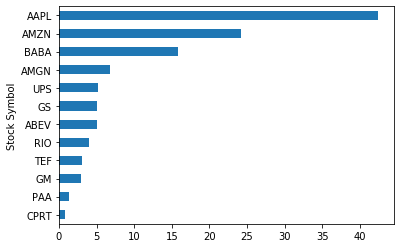

In [57]:
# Calculate and plot the contribution by component
weights.mul(index_return).sort_values().plot(kind='barh')
plt.show();

## Compare index performance against benchmark I

The next step in analyzing the performance of your index is to compare it against a benchmark. You can use the Dow Jones Industrial Average, which contains the 30 largest stocks, and would also be a reasonable benchmark for the largest stocks from all sectors across the three exchanges.

In [58]:
# Convert index series to dataframe here
data = index.to_frame('Index')

In [64]:
djia = pd.read_csv(path+'djia.csv', parse_dates=True, index_col='date')
djia

,djia
date,
2007-06-29,13408.62
2007-07-02,13535.43
2007-07-03,13577.30
2007-07-04,NaN
2007-07-05,13565.84
...,...
2017-06-23,21394.76
2017-06-26,21409.55
2017-06-27,21310.66


In [65]:
# Normalize djia series and add as new column to data
djia = djia.div(djia.iloc[0]).mul(100)
data['DJIA'] = djia

In [66]:
# Show total return for both index and djia
print((data.iloc[-1] / data.iloc[0] -1 ) * 100)

Index    116.486276
DJIA      86.722172
dtype: float64


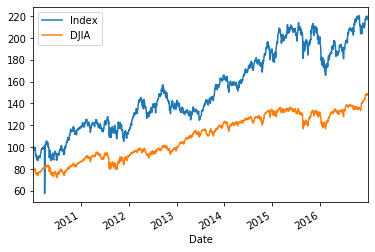

In [67]:
# Plot both series
data.plot()
plt.show();

## Compare index performance against benchmark II

The next step in analyzing the performance of your index is to compare it against a benchmark. You can use the Dow Jones Industrial Average, which contains the 30 largest stocks, and would also be a reasonable benchmark for the largest stocks from all sectors across the three exchanges.

In [68]:
data

,Index,DJIA
Date,,
2010-01-04,100.000000,78.933999
2010-01-05,100.508119,78.844952
2010-01-06,99.963872,78.857332
2010-01-07,99.435588,79.104785
2010-01-08,100.125141,79.189283
...,...,...
2016-12-23,218.262332,148.664143
2016-12-27,219.844835,148.747895
2016-12-28,219.249834,147.917384


In [69]:
# Inspect data
print(data.info())
print(data.head())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1762 entries, 2010-01-04 to 2016-12-30
Data columns (total 2 columns):
Index    1762 non-null float64
DJIA     1762 non-null float64
dtypes: float64(2)
memory usage: 121.3 KB
None
                 Index       DJIA
Date                             
2010-01-04  100.000000  78.933999
2010-01-05  100.508119  78.844952
2010-01-06   99.963872  78.857332
2010-01-07   99.435588  79.104785
2010-01-08  100.125141  79.189283


In [70]:
# Create multi_period_return function here
def multi_period_return(r):
    return (np.prod(r + 1) - 1) * 100

In [73]:
# Calculate rolling_return_360
rolling_return_360 = data.pct_change().rolling('360D').apply(multi_period_return)

/Users/ksatola/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
  


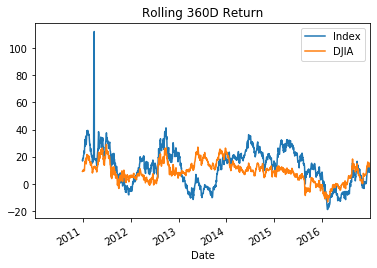

In [74]:
# Plot rolling_return_360 here
rolling_return_360.plot(title='Rolling 360D Return')
plt.show();

---
<a id='corr'></a>

## Index correlation & exporting to excel

## Visualize your index constituent correlations

To better understand the characteristics of your index constituents, you can calculate the return correlations. Use the daily stock prices or your index companies, and show a heatmap of the daily return correlations!

In [75]:
# Inspect stock_prices here
print(stock_prices.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1762 entries, 2010-01-04 to 2016-12-30
Data columns (total 12 columns):
AAPL    1761 non-null float64
AMGN    1761 non-null float64
AMZN    1761 non-null float64
CPRT    1761 non-null float64
EL      1762 non-null float64
GS      1762 non-null float64
ILMN    1761 non-null float64
MA      1762 non-null float64
PAA     1762 non-null float64
RIO     1762 non-null float64
TEF     1762 non-null float64
UPS     1762 non-null float64
dtypes: float64(12)
memory usage: 259.0 KB
None


In [77]:
# Calculate the daily returns
returns = stock_prices.pct_change()

In [78]:
# Calculate and print the pairwise correlations
correlations = returns.corr()
print(correlations)

          AAPL      AMGN      AMZN      CPRT        EL        GS      ILMN  \
AAPL  1.000000  0.286898  0.327611  0.346616  0.306770  0.344981  0.264791   
AMGN  0.286898  1.000000  0.323408  0.355892  0.349893  0.390076  0.336927   
AMZN  0.327611  0.323408  1.000000  0.298929  0.334031  0.333402  0.242726   
CPRT  0.346616  0.355892  0.298929  1.000000  0.371763  0.423160  0.265665   
EL    0.306770  0.349893  0.334031  0.371763  1.000000  0.358318  0.214027   
GS    0.344981  0.390076  0.333402  0.423160  0.358318  1.000000  0.266063   
ILMN  0.264791  0.336927  0.242726  0.265665  0.214027  0.266063  1.000000   
MA    0.391421  0.400230  0.428330  0.401352  0.431556  0.466796  0.301392   
PAA   0.212960  0.229255  0.182438  0.221273  0.206056  0.271982  0.162796   
RIO   0.361684  0.313878  0.326229  0.384944  0.415416  0.527298  0.234445   
TEF   0.325309  0.374555  0.331867  0.376767  0.428925  0.498230  0.231173   
UPS   0.366039  0.432468  0.378399  0.462716  0.456952  0.506407

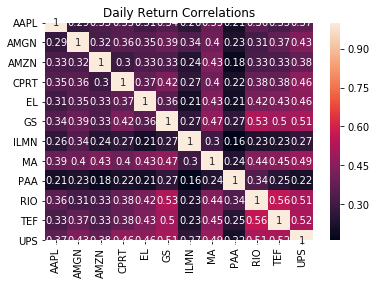

In [79]:
# Plot a heatmap of daily return correlations
sns.heatmap(correlations, annot=True)
plt.title('Daily Return Correlations')
plt.show();

## Save your analysis to multiple excel worksheets

Now that you have completed your analysis, you may want to save all results into a single Excel workbook. Let's practice exporting various DataFrame to multiple Excel worksheets.

In [83]:
index = pd.read_csv(path+'index.csv', parse_dates=True, index_col='Date')
index

,Index
Date,
2010-01-04,100.000000
2010-01-05,100.457394
2010-01-06,99.981005
2010-01-07,99.485328
2010-01-08,100.148231
...,...
2016-12-23,228.675001
2016-12-27,230.172669
2016-12-28,229.360223


In [84]:
# Inspect index and stock_prices
print(index.info())
print(stock_prices.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1761 entries, 2010-01-04 to 2016-12-30
Data columns (total 1 columns):
Index    1761 non-null float64
dtypes: float64(1)
memory usage: 27.5 KB
None
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1762 entries, 2010-01-04 to 2016-12-30
Data columns (total 12 columns):
AAPL    1761 non-null float64
AMGN    1761 non-null float64
AMZN    1761 non-null float64
CPRT    1761 non-null float64
EL      1762 non-null float64
GS      1762 non-null float64
ILMN    1761 non-null float64
MA      1762 non-null float64
PAA     1762 non-null float64
RIO     1762 non-null float64
TEF     1762 non-null float64
UPS     1762 non-null float64
dtypes: float64(12)
memory usage: 259.0 KB
None


In [85]:
# Join index to stock_prices, and inspect the result
data = stock_prices.join(index)
print(data.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1762 entries, 2010-01-04 to 2016-12-30
Data columns (total 13 columns):
AAPL     1761 non-null float64
AMGN     1761 non-null float64
AMZN     1761 non-null float64
CPRT     1761 non-null float64
EL       1762 non-null float64
GS       1762 non-null float64
ILMN     1761 non-null float64
MA       1762 non-null float64
PAA      1762 non-null float64
RIO      1762 non-null float64
TEF      1762 non-null float64
UPS      1762 non-null float64
Index    1761 non-null float64
dtypes: float64(13)
memory usage: 272.7 KB
None


In [86]:
# Create index & stock price returns
returns = data.pct_change()

In [88]:
# Export data and data as returns to excel
with pd.ExcelWriter(path+'data.xls') as writer:
    data.to_excel(writer, sheet_name='data')
    returns.to_excel(writer, sheet_name='returns')